# Phishing detector model: first snapshot

## Architecture idea

The model will be set-up as follows:
- Pre-trained RoBERTa Base Layer (Encoder)
- Additional Transformer Encoder Layer (Feature Enhancement)
- Classification Head (Binary Prediction)

Input text -> RoBERTa -> Transformer Layer -> Classification -> Head -> [Safe/Phishing]

## Component Breakdown

### RoBERta Base Model
A transformer-based language model pre-trained on massive text corpora, therefore being capable of providing rich linguistic understanding.
- It captures contextual meaning of words and phrases
- Understands semantic relationships crucial for detecting deceptive language

### Additional Transformer Layer
While RoBERTa understands general language, this layer learns phishing-specific patterns. The multi-head attention mechanism focuses on suspicious elements. And it may be possible for it to create more discriminative features for the final classification.

# Importing neccesary libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Import transformers components separately to avoid TF issues
import transformers
from transformers import RobertaTokenizer, RobertaModel, logging as transformers_logging
transformers_logging.set_verbosity_error()

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

print(f"✓ Imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

✓ Imports successful!
PyTorch version: 2.6.0+cu124
Transformers version: 4.53.3
Device: cuda


# Dataset Class

In [2]:
class PhishingDataset(Dataset):
    """Custom dataset for phishing detection"""
    def __init__(self, texts, types, labels, tokenizer, max_length=256):
        self.texts = texts
        self.types = types
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        phishing_type = self.types[idx]
        label = self.labels[idx]

        # Add type prefix to help model distinguish
        prefix = "[EMAIL] " if phishing_type == "email" else "[URL] "
        text = prefix + text

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

print("✓ PhishingDataset class defined")


✓ PhishingDataset class defined


# Detection Model Class

In [3]:
class PhishingDetector(nn.Module):
    """RoBERTa + Additional Transformer Layer for Phishing Detection"""
    def __init__(self, dropout_rate=0.3):
        super(PhishingDetector, self).__init__()

        # Load pre-trained RoBERTa
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        hidden_size = self.roberta.config.hidden_size

        # Additional transformer layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=8,
            dim_feedforward=2048,
            dropout=dropout_rate,
            activation='gelu',
            batch_first=True
        )
        self.transformer_layer = nn.TransformerEncoder(encoder_layer, num_layers=1)

        # Classification head
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 2)

    def forward(self, input_ids, attention_mask):
        # RoBERTa encoding
        roberta_output = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Get sequence output
        sequence_output = roberta_output.last_hidden_state

        # Additional transformer layer
        transformer_output = self.transformer_layer(sequence_output)

        # Use [CLS] token
        cls_output = transformer_output[:, 0, :]

        # Classification
        x = self.dropout(cls_output)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        logits = self.fc2(x)

        return logits

print("✓ PhishingDetector class defined")

✓ PhishingDetector class defined


# Loading data from CSV


In [4]:
import pandas as pd

# Kaggle automatically mounts datasets to /kaggle/input/
# Replace 'your-dataset-name' with your actual dataset name
df = pd.read_csv('/kaggle/input/phishingdataset/decphi_dataset (1).csv')

# Verify required columns exist
required_cols = ['phishing_data', 'phishing_type', 'phishing_class']
missing_cols = [col for col in required_cols if col not in df.columns]

if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

print(f"\n✓ Loaded {len(df)} records from CSV")
print(f"\nClass distribution:")
print(df['phishing_class'].value_counts())
print(f"\nType distribution:")
print(df['phishing_type'].value_counts())
print(f"\nFirst few rows:")
df.head()

df_sampled = df.groupby('phishing_class', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 60000), random_state=42)
).reset_index(drop=True)

print(f"Using {len(df_sampled)} samples for training")
df = df_sampled

# ==================== CHECK TYPE DISTRIBUTION ====================
print("\nType distribution in sampled data:")
print(df_sampled.groupby(['phishing_class', 'phishing_type']).size())
print("\nPercentage breakdown:")
print(df_sampled.groupby(['phishing_class', 'phishing_type']).size() / len(df_sampled) * 100)


✓ Loaded 840660 records from CSV

Class distribution:
phishing_class
1    434356
0    406304
Name: count, dtype: int64

Type distribution:
phishing_type
URL     822010
Mail     18650
Name: count, dtype: int64

First few rows:
Using 120000 samples for training

Type distribution in sampled data:
phishing_class  phishing_type
0               Mail              1641
                URL              58359
1               Mail              1012
                URL              58988
dtype: int64

Percentage breakdown:
phishing_class  phishing_type
0               Mail              1.367500
                URL              48.632500
1               Mail              0.843333
                URL              49.156667
dtype: float64


# Peparing data splits

In [5]:
def prepare_data(df, test_size=0.2, val_size=0.1):
    """Prepare train, validation, and test datasets"""
    # Remove null values
    df = df.dropna(subset=['phishing_data', 'phishing_type', 'phishing_class'])

    X = df['phishing_data'].values
    y = df['phishing_class'].values
    types = df['phishing_type'].values

    # Split: train+val and test
    X_temp, X_test, y_temp, y_test, types_temp, types_test = train_test_split(
        X, y, types, test_size=test_size, random_state=42, stratify=y
    )

    # Split: train and val
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val, types_train, types_val = train_test_split(
        X_temp, y_temp, types_temp, test_size=val_ratio, random_state=42, stratify=y_temp
    )

    print(f"\n✓ Dataset splits:")
    print(f"  Train: {len(X_train)} samples")
    print(f"  Validation: {len(X_val)} samples")
    print(f"  Test: {len(X_test)} samples")

    return (X_train, y_train, types_train), (X_val, y_val, types_val), (X_test, y_test, types_test)

train_data, val_data, test_data = prepare_data(df)


✓ Dataset splits:
  Train: 83996 samples
  Validation: 12000 samples
  Test: 24000 samples


# Create datasets and dataloaders

In [6]:
print("Loading tokenizer...")
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Create datasets
train_dataset = PhishingDataset(train_data[0], train_data[2], train_data[1], tokenizer)
val_dataset = PhishingDataset(val_data[0], val_data[2], val_data[1], tokenizer)
test_dataset = PhishingDataset(test_data[0], test_data[2], test_data[1], tokenizer)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"✓ Datasets and DataLoaders created")
print(f"  Batch size: {batch_size}")
print(f"  Training batches: {len(train_loader)}")

Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

✓ Datasets and DataLoaders created
  Batch size: 64
  Training batches: 1313


# Clearing GPU Memory

In [7]:
import gc

if 'model' in globals():
    del model
    
# Clear cache
torch.cuda.empty_cache()
gc.collect()

print("✓ GPU memory cleared")
print(f"GPU Memory allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
print(f"GPU Memory reserved: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")

✓ GPU memory cleared
GPU Memory allocated: 0.52 GB
GPU Memory reserved: 0.58 GB


# Model Initialization

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = PhishingDetector(dropout_rate=0.3).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Model initialized")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

Using device: cuda


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]


✓ Model initialized
  Total parameters: 130,356,994
  Trainable parameters: 130,356,994


# Model Training Function Definition


In [9]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """Train for one epoch"""
    model.train()
    train_loss = 0
    train_preds = []
    train_labels = []

    progress_bar = tqdm(train_loader, desc='Training')
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = train_loss / len(train_loader)
    accuracy = accuracy_score(train_labels, train_preds)

    return avg_loss, accuracy

def validate(model, val_loader, device):
    """Validate the model"""
    model.eval()
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)

            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(val_labels, val_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        val_labels, val_preds, average='binary'
    )

    return accuracy, precision, recall, f1

print("✓ Training functions defined")


✓ Training functions defined


# Checkpoint functions for training persistence

In [10]:
def save_checkpoint(model, optimizer, epoch, best_val_acc, history, filename='/kaggle/working/checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_acc': best_val_acc,
        'history': history
    }, filename)
    print(f"Checkpoint saved at epoch {epoch+1}")

def load_checkpoint(model, optimizer, filename='kaggle/working/checkpoint.pth'):
    if os.path.exists(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_acc = checkpoint['best_val_acc']
        history = checkpoint['history']
        print(f"Resumed from epoch {start_epoch}")
        return start_epoch, best_val_acc, history
    return 0, 0, {'train_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': []}

print("Checkpoint functions defined")

Checkpoint functions defined


# Training

In [11]:
epochs = 5
learning_rate = 2e-5

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2
)

# Try to load checkpoint if exists (for resuming interrupted training)
start_epoch, best_val_acc, history = load_checkpoint(model, optimizer)

print("Starting training...\n")

for epoch in range(start_epoch, epochs):
    print(f"{'='*60}")
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"{'='*60}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    
    # Validate
    val_acc, precision, recall, f1 = validate(model, val_loader, device)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(f1)
    
    print(f"\nResults:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Acc: {val_acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
    
    # Save best model in memory
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        print(f"  ✓ New best model! (Val Acc: {val_acc:.4f})")
        
        # Also save best model to disk immediately
        torch.save({
            'model_state_dict': best_model_state,
            'val_accuracy': best_val_acc,
            'epoch': epoch + 1,
            'history': history
        }, '/kaggle/working/best_model.pth')
        print(f"  ✓ Best model saved to disk!")
    
    # Save checkpoint every epoch
    save_checkpoint(model, optimizer, epoch, best_val_acc, history)
    
    scheduler.step(val_acc)
    print()

# Load best model
model.load_state_dict(best_model_state)
print(f"\n{'='*60}")
print(f"Training complete! Best validation accuracy: {best_val_acc:.4f}")
print(f"{'='*60}")

# Save final checkpoint
print("\nSaving final checkpoint...")
torch.save({
    'model_state_dict': best_model_state,
    'best_val_acc': best_val_acc,
    'history': history,
    'training_complete': True
}, '/kaggle/working/final_model.pth')
print("✓ Final model saved!")

Starting training...

Epoch 1/5


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]


Results:
  Train Loss: 0.1225 | Train Acc: 0.9560
  Val Acc: 0.9751 | Precision: 0.9800 | Recall: 0.9700 | F1: 0.9750
  ✓ New best model! (Val Acc: 0.9751)
  ✓ Best model saved to disk!
Checkpoint saved at epoch 1

Epoch 2/5


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]


Results:
  Train Loss: 0.0639 | Train Acc: 0.9790
  Val Acc: 0.9796 | Precision: 0.9774 | Recall: 0.9818 | F1: 0.9796
  ✓ New best model! (Val Acc: 0.9796)
  ✓ Best model saved to disk!
Checkpoint saved at epoch 2

Epoch 3/5


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]


Results:
  Train Loss: 0.0487 | Train Acc: 0.9846
  Val Acc: 0.9792 | Precision: 0.9889 | Recall: 0.9692 | F1: 0.9790
Checkpoint saved at epoch 3

Epoch 4/5


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]


Results:
  Train Loss: 0.0367 | Train Acc: 0.9893
  Val Acc: 0.9828 | Precision: 0.9814 | Recall: 0.9843 | F1: 0.9829
  ✓ New best model! (Val Acc: 0.9828)
  ✓ Best model saved to disk!
Checkpoint saved at epoch 4

Epoch 5/5


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]


Results:
  Train Loss: 0.0291 | Train Acc: 0.9918
  Val Acc: 0.9822 | Precision: 0.9761 | Recall: 0.9887 | F1: 0.9824
Checkpoint saved at epoch 5


Training complete! Best validation accuracy: 0.9828

Saving final checkpoint...
✓ Final model saved!


# Evaluate on Test Set

In [12]:
# 1. Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# 2. Recreate model
print("Recreating model...")
model = PhishingDetector(dropout_rate=0.3).to(device)

# 3. Load weights
if 'best_model_state' in globals():
    model.load_state_dict(best_model_state)
    print("✓ Loaded from best_model_state")
elif os.path.exists('checkpoint.pth'):
    checkpoint = torch.load('checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print("✓ Loaded from checkpoint")
elif os.path.exists('/kaggle/working/checkpoint.pth'):
    checkpoint = torch.load('/kaggle/working/checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print("✓ Loaded from /kaggle/working/checkpoint")
else:
    print("❌ No weights found!")

model.eval()
print("✓ Model ready\n")

# 4. Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    test_preds = []
    test_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Testing'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)
            
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(test_labels, test_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='binary')
    cm = confusion_matrix(test_labels, test_preds)
    
    print(f"\n{'='*60}")
    print("FINAL TEST SET RESULTS")
    print(f"{'='*60}")
    print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"\nConfusion Matrix:")
    print(f"  TN: {cm[0][0]:4d} | FP: {cm[0][1]:4d}")
    print(f"  FN: {cm[1][0]:4d} | TP: {cm[1][1]:4d}")
    print(f"{'='*60}")
    
    return accuracy, precision, recall, f1, cm

# 5. Run evaluation
print("Starting evaluation...")
test_acc, test_precision, test_recall, test_f1, cm = evaluate_model(model, test_loader, device)

Device: cuda
Recreating model...
✓ Loaded from best_model_state
✓ Model ready

Starting evaluation...


Testing:   0%|          | 0/375 [00:00<?, ?it/s]


FINAL TEST SET RESULTS
Accuracy:  0.9820 (98.20%)
Precision: 0.9757
Recall:    0.9886
F1-Score:  0.9821

Confusion Matrix:
  TN: 11705 | FP:  295
  FN:  137 | TP: 11863


# Save Model

In [13]:
import pickle
# import torch

# Prepare model data
model_data = {
    'model_state_dict': model.state_dict(),
    'model_config': {
        'dropout_rate': 0.3,
        'architecture': 'RoBERTa + Transformer',
        'hidden_size': 768,
        'num_classes': 2
    },
    'test_accuracy': test_acc,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_f1': test_f1,
    'history': history,
    'tokenizer_name': 'roberta-base',
    'max_length': 256,
    'best_val_acc': best_val_acc if 'best_val_acc' in globals() else max(history['val_acc'])
}

# Save as PKL
with open('phishing_detector_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("✓ Model saved to 'phishing_detector_model.pkl'")

# Also save as PTH for PyTorch compatibility (recommended to keep both)
torch.save(model_data, 'phishing_detector_model.pth')
print("✓ Model also saved to 'phishing_detector_model.pth'")

print("\n" + "="*50)
print("SAVED MODEL DETAILS:")
print("="*50)
print(f"Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Test F1-Score:  {test_f1:.4f}")
print("="*50)

✓ Model saved to 'phishing_detector_model.pkl'
✓ Model also saved to 'phishing_detector_model.pth'

SAVED MODEL DETAILS:
Test Accuracy:  0.9820 (98.20%)
Test Precision: 0.9757
Test Recall:    0.9886
Test F1-Score:  0.9821


# Visualize training history

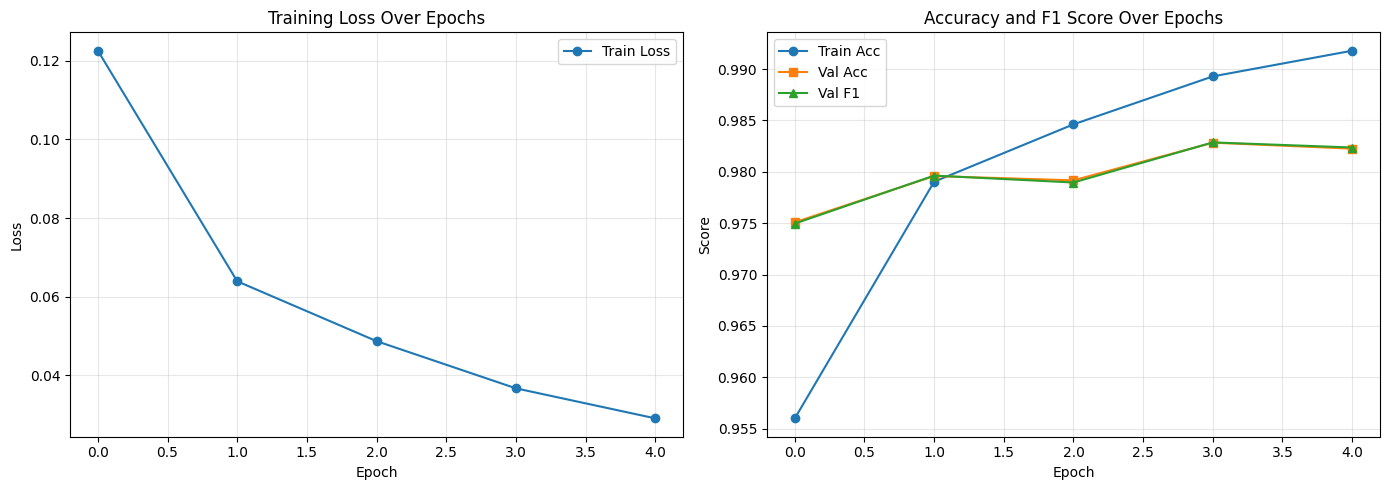

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss and Accuracy
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Over Epochs')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Validation Metrics
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].plot(history['val_f1'], label='Val F1', marker='^')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Accuracy and F1 Score Over Epochs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Prediction Function for testing definition

In [15]:
def predict_single(model, tokenizer, text, phishing_type, device):
    """Make prediction on a single sample"""
    model.eval()

    prefix = "[EMAIL] " if phishing_type == "email" else "[URL] "
    text = prefix + text

    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probs = torch.softmax(logits, dim=1)
        pred = torch.argmax(logits, dim=1)

    confidence = probs[0][pred].item()
    prediction = "PHISHING" if pred.item() == 1 else "SAFE"

    return prediction, confidence

print("✓ Prediction function defined")

✓ Prediction function defined


# Prediction Test

In [16]:
print(f"\n{'='*60}")
print("EXAMPLE PREDICTIONS")
print(f"{'='*60}\n")

examples = [
    ("Click here to verify your account: http://paypal-verify.com/login", "url"),
    ("https://www.google.com", "url"),
    ("Congratulations! You've won $1,000,000. Send your bank details now!", "email"),
    ("Meeting scheduled for tomorrow at 2 PM in conference room A.", "email")
]

for i, (text, ptype) in enumerate(examples, 1):
    pred, conf = predict_single(model, tokenizer, text, ptype, device)
    print(f"Example {i}:")
    print(f"  Text: {text[:70]}...")
    print(f"  Type: {ptype}")
    print(f"  Prediction: {pred} (Confidence: {conf:.4f})")
    print()


EXAMPLE PREDICTIONS

Example 1:
  Text: Click here to verify your account: http://paypal-verify.com/login...
  Type: url
  Prediction: SAFE (Confidence: 0.9971)

Example 2:
  Text: https://www.google.com...
  Type: url
  Prediction: PHISHING (Confidence: 0.9919)

Example 3:
  Text: Congratulations! You've won $1,000,000. Send your bank details now!...
  Type: email
  Prediction: PHISHING (Confidence: 0.9998)

Example 4:
  Text: Meeting scheduled for tomorrow at 2 PM in conference room A....
  Type: email
  Prediction: SAFE (Confidence: 0.9999)

